In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Probably an important note, I think the connections between everything except the cortex-striatum have to be perfectly one to one, otherwise the recurrant connections just excite themselves more and mroe and the range of activated neurons spreads.... the distribtution of thalamic layer neurons that are active gets wider and wider. 

In [37]:
class b_ganglia:
    def __init__(self,n_loops,time_steps,exc_spread1):

        self.n_loops = n_loops
        self.n_steps = time_steps

        #activations for all units
        self.a_sd1 = np.zeros((time_steps, n_loops))
        self.a_sd2 = np.zeros((time_steps, n_loops))
        self.a_stn = np.zeros((time_steps, n_loops))
        self.a_gpi = np.ones((time_steps, n_loops))
        self.a_gpe = np.zeros((time_steps, n_loops))
        self.a_tha = np.zeros((time_steps, n_loops))
        self.a_ctx = np.zeros((time_steps, n_loops))

        #vector to hold changing dopamine levels
        self.da = np.ones((time_steps))

        #vector to hold the inputs...
        self.a_inp = np.ones((time_steps, n_loops))


        #variable to keep track of what step we are currently on
        self.c = 0

        ####               weights connecting all the layers    #####

        #cortico-striatal connections are topographical, but also overlapping, thus we will use the Guassians we have previously shown work
        #first change from the original version, we will not have "input"-striatum connections, we will have a single cortical layer at the top receiving both "input" and thalamic input

        #initializing the matrices to hold all the weights
        self.w_ctx_sd1 = np.zeros((n_loops,n_loops))
        self.w_ctx_sd2 = np.zeros((n_loops,n_loops))


        #the weights from input to the cortex will just be the identity matrix I think
        self.w_inp_ctx = np.identity(n_loops) * 6


        unit_ids = np.arange(0,n_loops,1)        
        for i in range(0,n_loops):
            #inserting the Guassians into the matrix
            #wider-spreading connectivities
            self.w_ctx_sd1[i] = stats.norm.pdf(unit_ids, i, exc_spread1) / np.max(stats.norm.pdf(unit_ids, i, exc_spread1)) * 0.5 #the dividing by the max ensure the weight distribution has a max of 1 before any other changes, just keeps the weights reasonable I think
            self.w_ctx_sd2[i] = stats.norm.pdf(unit_ids, i, exc_spread1) / np.max(stats.norm.pdf(unit_ids, i, exc_spread1)) * 0.5

        #second attempt at this, implementing pure 1-to-1 connectivity
        self.w_ctx_stn = np.identity(n_loops) * 1.5
        self.w_sd1_gpi = np.identity(n_loops) * -25
        self.w_sd2_gpe = np.identity(n_loops) * 0
        self.w_gpe_stn = np.identity(n_loops) * 0
        self.w_gpe_gpi = np.identity(n_loops) * 0
        self.w_gpi_tha = np.identity(n_loops) * -12
        self.w_tha_ctx = np.identity(n_loops) * 5.5

        #the STN has dense connectivity to the output nuclei so we can just set these as an array of ones
        self.w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 0.2  
        self.w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 0 

        #previous weight matrices for reference...
        '''
        w_inp_sd1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 8
        w_inp_sd2 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 8
        w_ctx_sd1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12
        w_ctx_sd2 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12
        w_ctx_stn = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12 
        w_sd1_gpi = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -25 
        w_sd2_gpe = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -15
        w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 10
        w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 2
        w_gpe_stn = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -13
        w_gpe_gpi = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -4
        w_gpi_tha = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -45
        w_tha_ctx = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 40 
        '''

    #uses euler integration to calculate the activation at each unit in the model of the basal ganglia 
    def step(self, i):

        #likely easier to just define the parameters inside this function...
        dt = 0.001
        tau = 0.01
        #time constant 
        h= dt/tau

        #define the sensitivies to dopamine and normal response
        sd1_bl = 0.1
        sd1_DA = 0.9
        sd2_bl = 1
        sd2_DA = 10



        #vector containing abstract representation of activity in different cortical areas, receives user determined input, and connections from the thalamus
        self.a_ctx[i+1] = self.non_lin(h * (-1 * self.a_ctx[i] + (np.matmul(self.input[i], self.w_inp_ctx)) + (np.matmul(self.a_tha[i], self.w_tha_ctx))))
        
        #input to direct pathway of striatum, cortical input modulated by dopamine
        self.a_sd1[i+1] = self.non_lin(h * (-1 * self.a_sd1[i] + (sd1_bl + sd1_DA * self.da[i]) * (np.matmul(self.a_ctx[i], self.w_ctx_sd1))))

        #input to sd2 modulated by dopamine
        self.a_sd2[i+1] = self.non_lin(h * (-1 * self.a_sd2[i] + (1/(sd2_bl + sd2_DA * self.da[i])) * ((np.matmul(self.a_ctx[i], self.w_ctx_sd2))))) 

        #input to stn from ctx and gpe
        self.a_stn[i+1] = self.non_lin(h * (-1 * self.a_stn[i] + (np.matmul(self.a_ctx[i], self.w_ctx_stn)) + np.matmul(self.a_gpe[i], self.w_gpe_stn)+3))

        #input to gpe from stn and sd2
        self.a_gpe[i+1] = self.non_lin(h * (-1 * self.a_gpe[i] + (np.matmul(self.a_sd2[i], self.w_sd2_gpe)) + (np.matmul(self.a_stn[i], self.w_stn_gpe)) + 8 ))

        #input to gpi from strd1, stn, and gpe 
        self.a_gpi[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] + (np.matmul(self.a_sd1[i], self.w_sd1_gpi))+ (np.matmul(self.a_stn[i], self.w_stn_gpi)) + (np.matmul(self.a_gpe[i], self.w_gpe_gpi))+4))

        #input to thalamus from gpi 
        self.a_tha[i+1] = self.non_lin(h * (-1 * self.a_tha[i] + (np.matmul(self.a_gpi[i], self.w_gpi_tha))+ 10))


        
        self.c += 1

        return None

    #non-linearity to generate activations
    def non_lin(self,vec):

        #apply non-linearity
        x = np.tanh(vec)
        
        #set any negative values to 0
        for i in range(self.n_loops):
            if x[i] < 0:
                x[i] = 0
        
        return x

    def run(self, steps, input, dopamine):

        self.input = input.T
        self.da = dopamine

        
        for i in range(steps):
            self.step(self.c)

        
    def display(self):

        titles = ('Input','Ctx', 'SD1', 'SD2', "STN", "GPi/SNpr", "GPe", "Tha")
        data = (self.input,  self.a_ctx, self.a_sd1, self.a_sd2, self.a_stn, self.a_gpi, self.a_gpe, self.a_tha)

        fig, ax = plt.subplots(8)
        fig.set_figheight(20)
        fig.set_figwidth(15)
        fig.tight_layout()

        for i in range(8):
            im = ax[i].imshow(data[i][20:].T,aspect='auto')
            ax[i].set_title(titles[i])
            plt.colorbar(im, ax=ax[i])
        
        fig2, ax = plt.subplots(8)
        fig2.set_figheight(20)
        fig2.set_figwidth(15)
        fig2.tight_layout()

        for i in range(8):
            time_steps = np.arange(0,self.n_steps,10)
            for step in time_steps:
                ax[i].plot(data[i][step],alpha=0.5,label= str("step = "+str(step)))
                ax[i].set_title(titles[i])
                ax[i].legend()

               

        
        plt.show

        return None


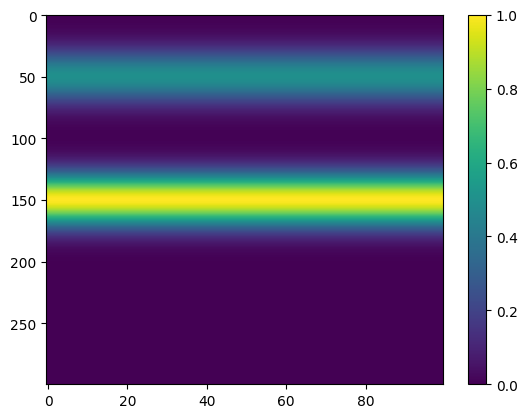

In [31]:
#like the first time we did this, making some input sequences...
### case 1, simple Gaussian bump about a third of the way into the line
n_units = 300
n_steps = 100
sd = 15 
case1 = np.zeros((n_units,n_steps))

unit_ids = np.arange(0,n_units,1)
for i in range(0,n_steps):
    case1[:,i] = stats.norm.pdf(unit_ids,150, sd) / np.max(stats.norm.pdf(unit_ids,150, sd)) + stats.norm.pdf(unit_ids,50, sd) / np.max(stats.norm.pdf(unit_ids,50, sd)) * 0.5

plt.imshow(case1,aspect="auto")
plt.colorbar()



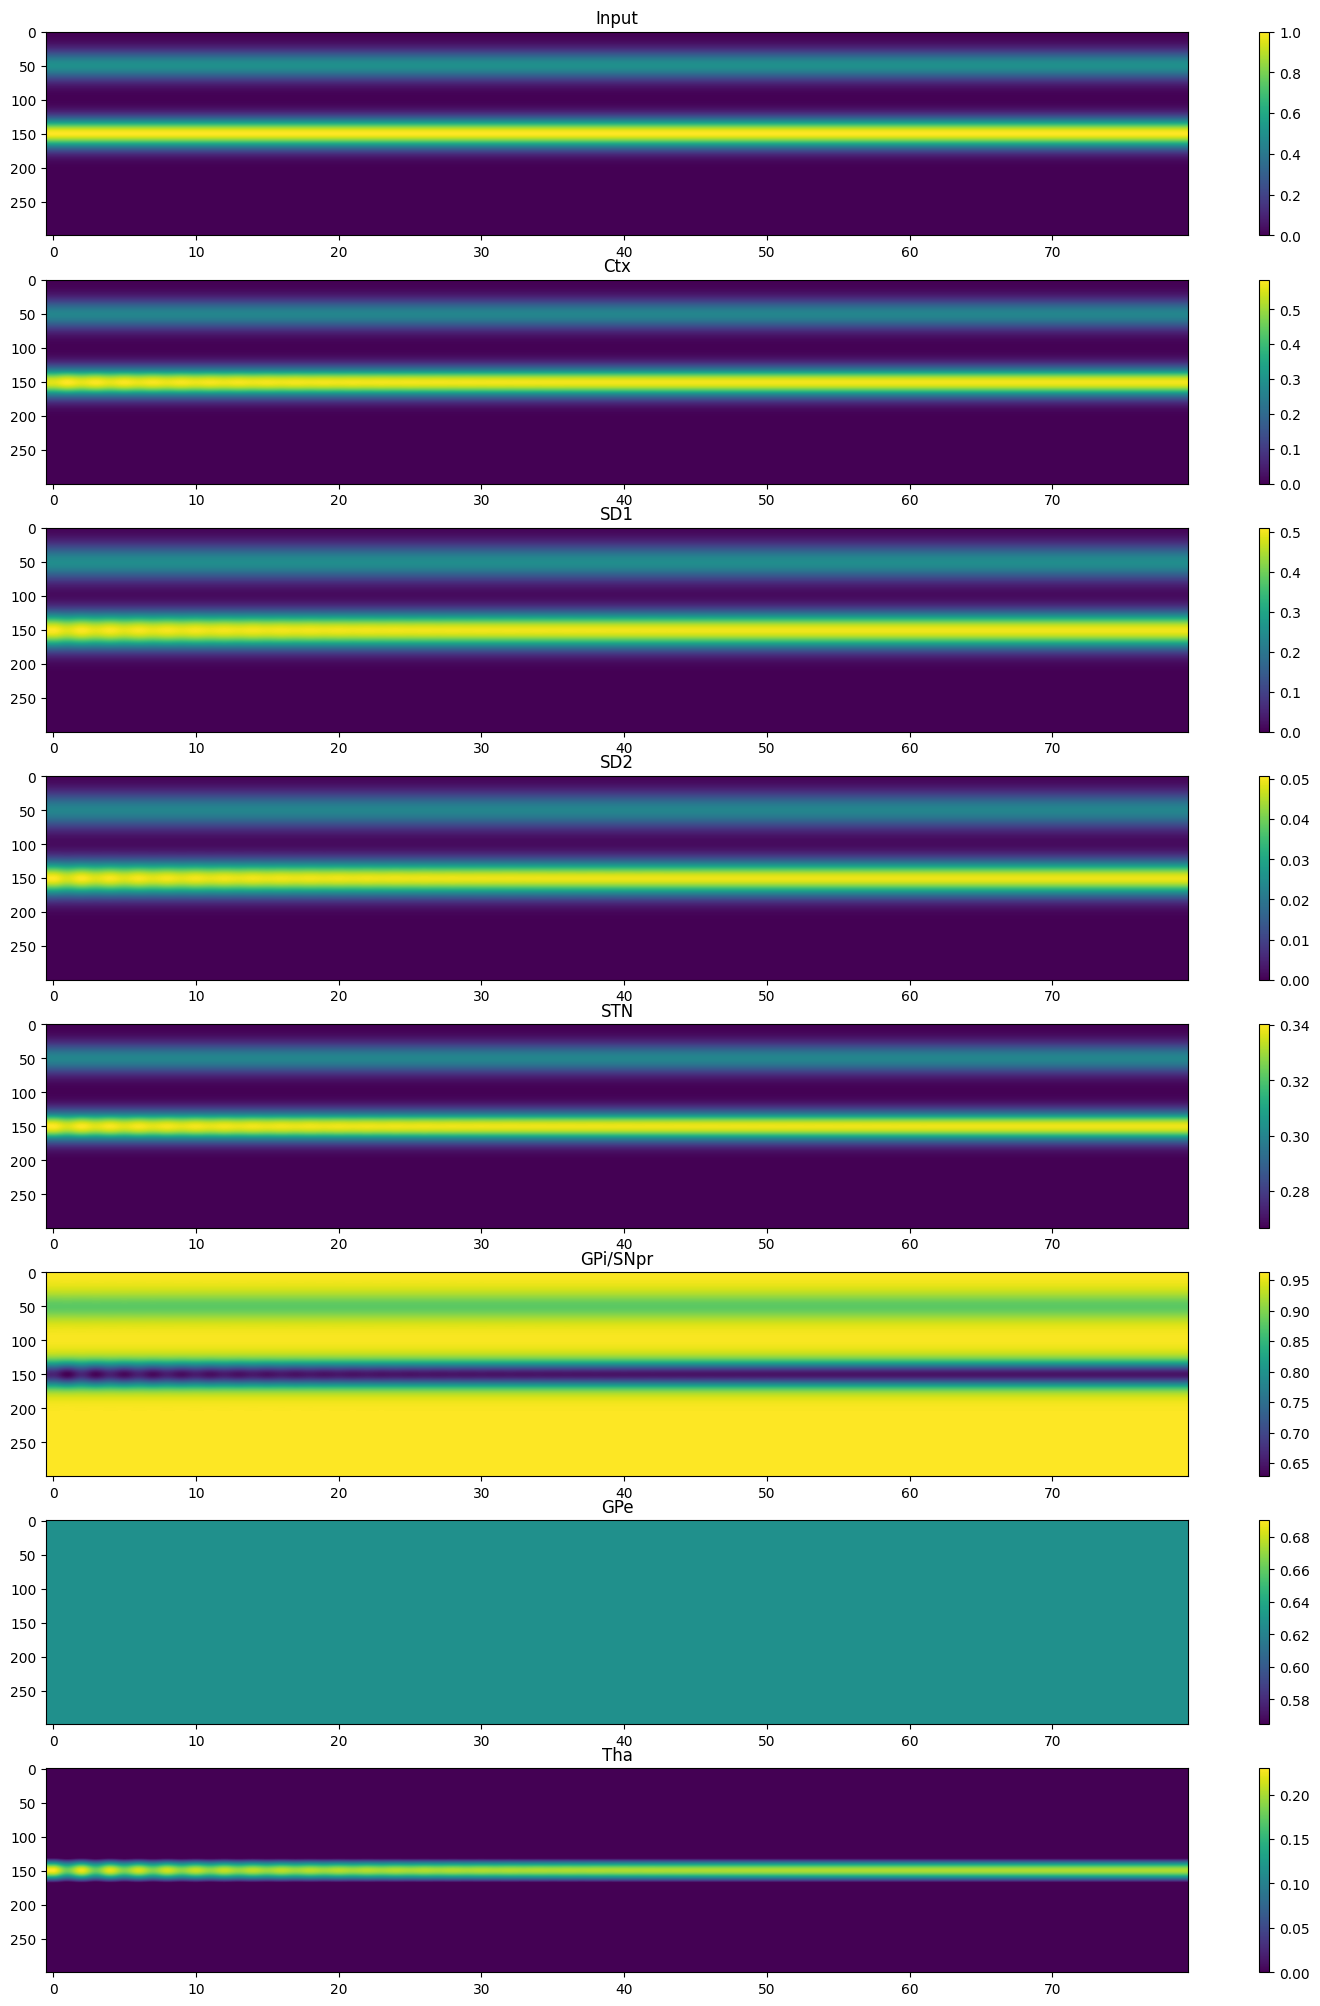

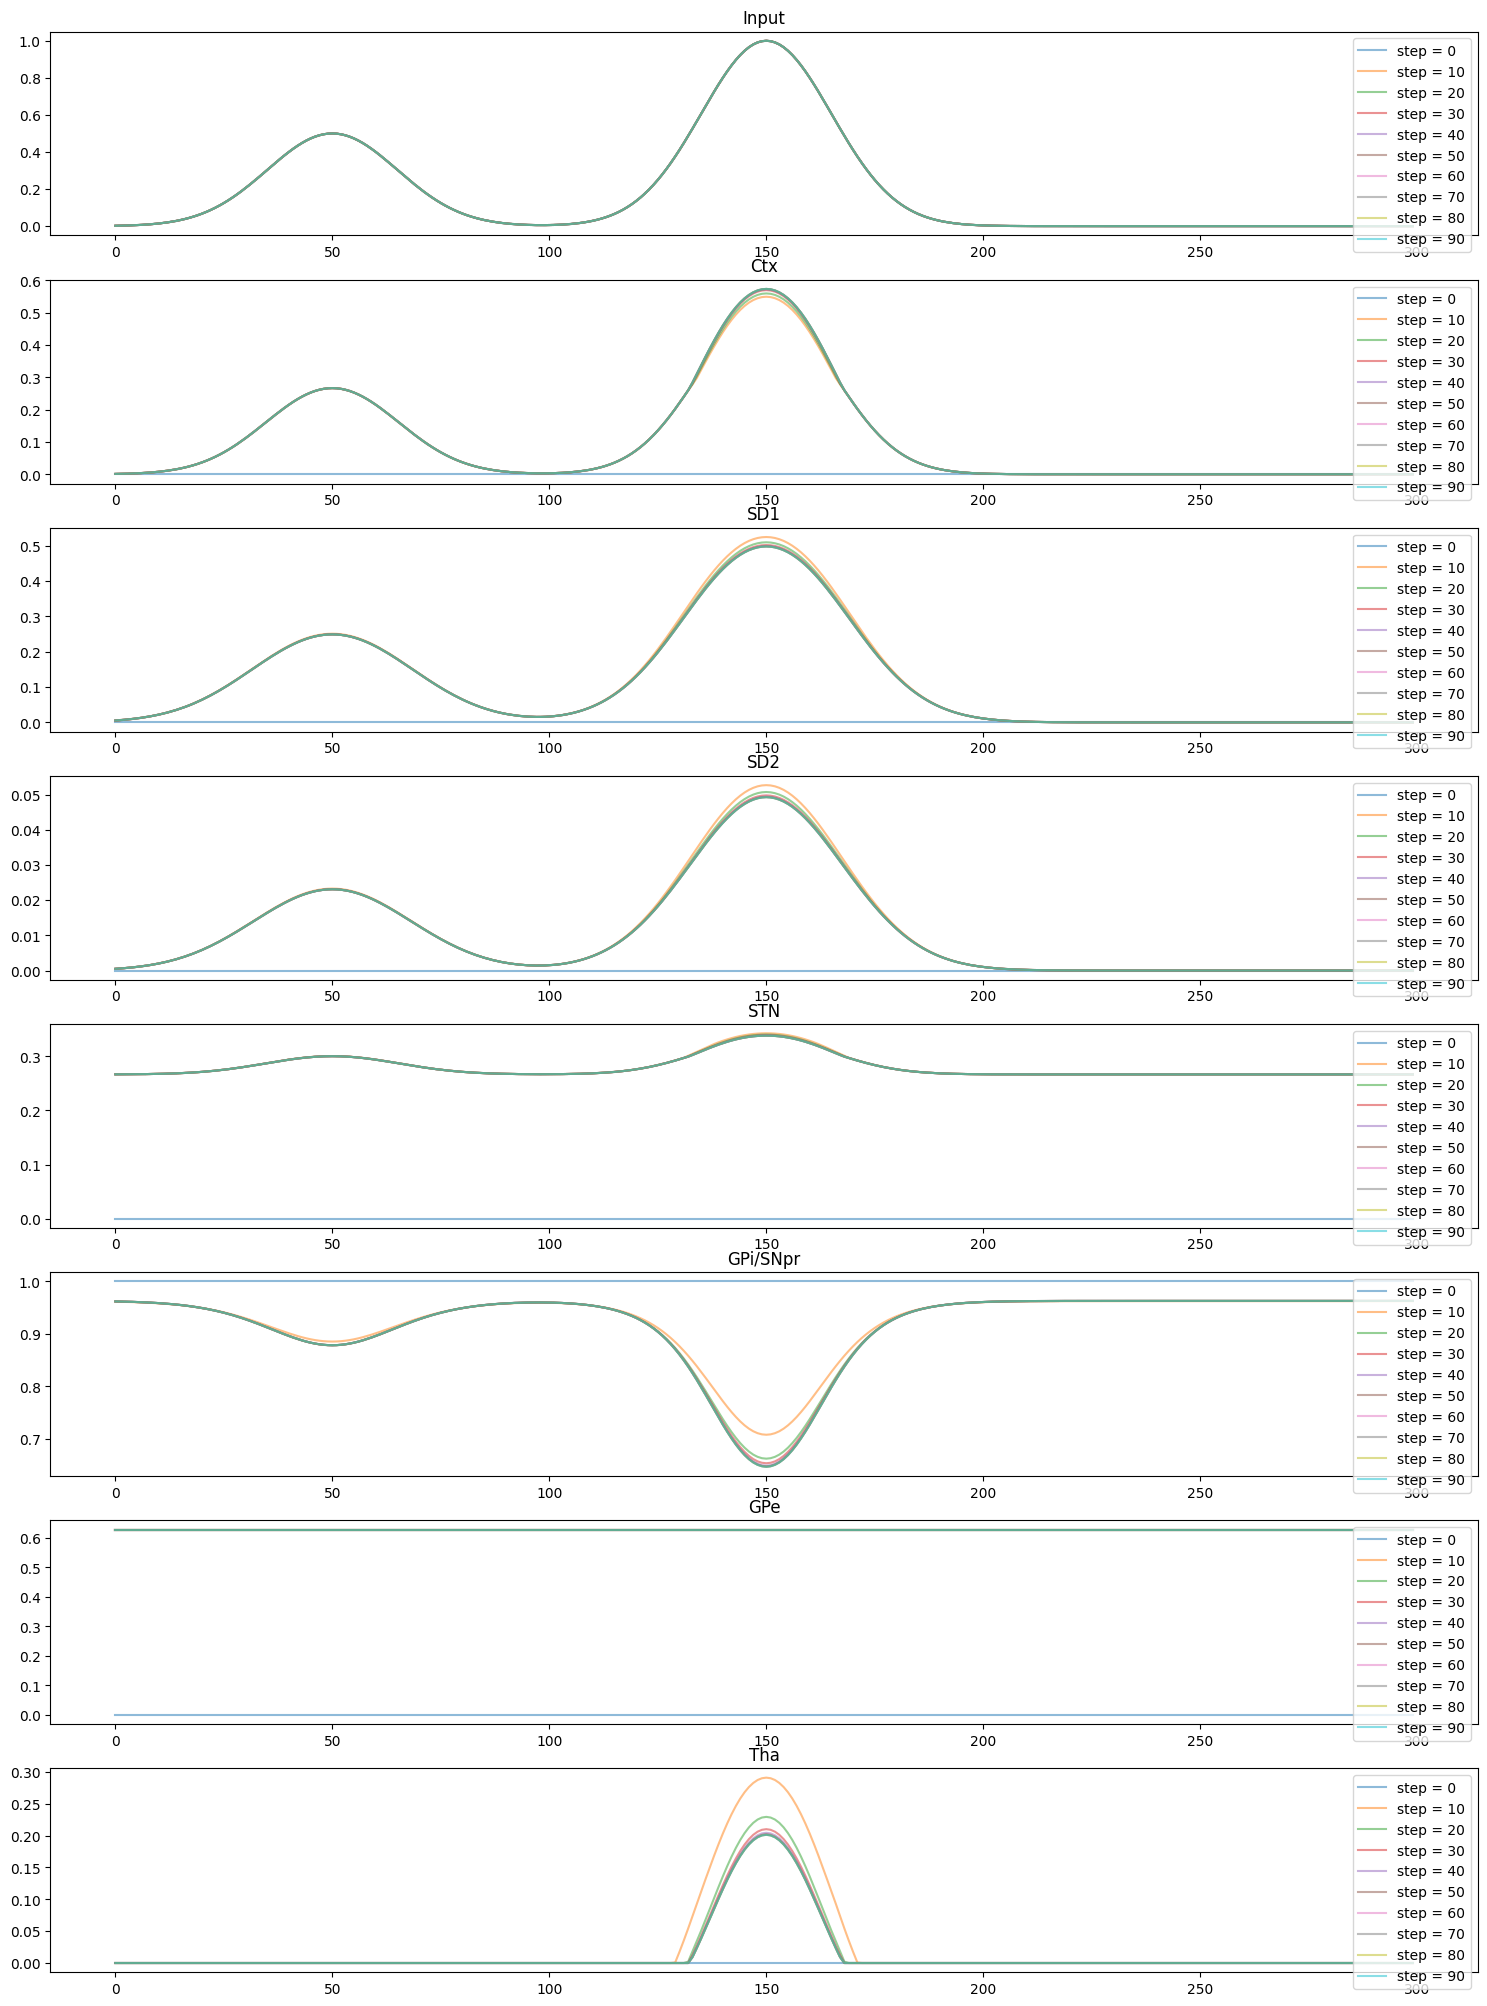

In [38]:
bg = b_ganglia(n_loops=300, time_steps=100, exc_spread1=10)
bg.run(99,case1,np.ones(300))
bg.display()
